## Cancer Detection
For this project, we will be predicting the presence of tumor tissue within pathology images. <br>
We will be designing our CNN architecture to be efficient, due to resource limitations, and accurate, due to the nature of the problem. <br><br>

Replicating this code will require some tweaks. All training was done within 'train.py'. To replicate the training process, run that file separately and ensure you have an accessible GPU.<br>
This notebook serves as a walkthrough of our approach and reasoning for ending up with the final iteration, (in 'train.py').

In [8]:
import pandas as pd
import numpy as np

import zipfile
import os

import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

### Download the images.
All data can be found here: https://www.kaggle.com/competitions/histopathologic-cancer-detection <br>
Don't bother unzipping the files, we will do it in code next.

### Unzip dense folders

In [19]:
#       This cell unzips files faster than Windows explorer. Skip if already unzipped

# Unzip train.zip
os.makedirs("train", exist_ok=True)
with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("train")

# Unzip test.zip
os.makedirs("test", exist_ok=True)
with zipfile.ZipFile("test.zip", 'r') as zip_ref:
    zip_ref.extractall("test")

FileNotFoundError: [Errno 2] No such file or directory: 'train.zip'

## Preprocessing
To read such a large set of images, we will use PyTorch to load the data and train the model.

In [ ]:
#           train folder
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

class ImageDF(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_id = row['id']
        label = row['label']
        img_path = os.path.join(self.root_dir, img_id + ".tif")

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"[WARNING] Failed to load image {img_path}: {e}")
            image = torch.zeros((3, 46, 46))  # black dummy image

        return image, label


##### Transform the Data
Let's normalize the pixel values. This is necessary for our CNN to perform well.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((46, 46)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load labels CSV
labels_df = pd.read_csv('train/_labels.csv')

# Create dataset instance
df = ImageDF(dataframe=labels_df, root_dir='train', transform=transform)

### Data Inspection

In [ ]:
for i in range(5):  # Inspect the first 5 items
    image, label = df[i]
    print(f"Image {df.data.iloc[i, 0]}:")
    print(f"  Label: {label}")
    print(f"  Image shape: {image.shape}")
    print('-' * 10)

Image f38a6374c348f90b587e046aac6079959adf3835:
  Label: 0
  Image shape: torch.Size([3, 46, 46])
----------
Image c18f2d887b7ae4f6742ee445113fa1aef383ed77:
  Label: 1
  Image shape: torch.Size([3, 46, 46])
----------
Image 755db6279dae599ebb4d39a9123cce439965282d:
  Label: 0
  Image shape: torch.Size([3, 46, 46])
----------
Image bc3f0c64fb968ff4a8bd33af6971ecae77c75e08:
  Label: 0
  Image shape: torch.Size([3, 46, 46])
----------
Image 068aba587a4950175d04c680d38943fd488d6a9d:
  Label: 0
  Image shape: torch.Size([3, 46, 46])
----------


Looks good! <br>
Each row in the dataframe contains: <br>
1. an array of size (96,96,3) with depth = 3 corresponding to RGB
2. Labels corresponding to cancer detected or not

The entire training set is comprised of 220,025 images.

In [ ]:
df.data.iloc[:,1].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

Positive responses account for 40% of the data; a  good amount of cancerous and noncancerous images.

### Problem Description

If it's not aparent already, we are working with a cancer detection dataset pulled from Kaggle (source above). <br>
To predict the presence of cancer, we will try different approaches, all utilizing CNN architecture.

### Visualization

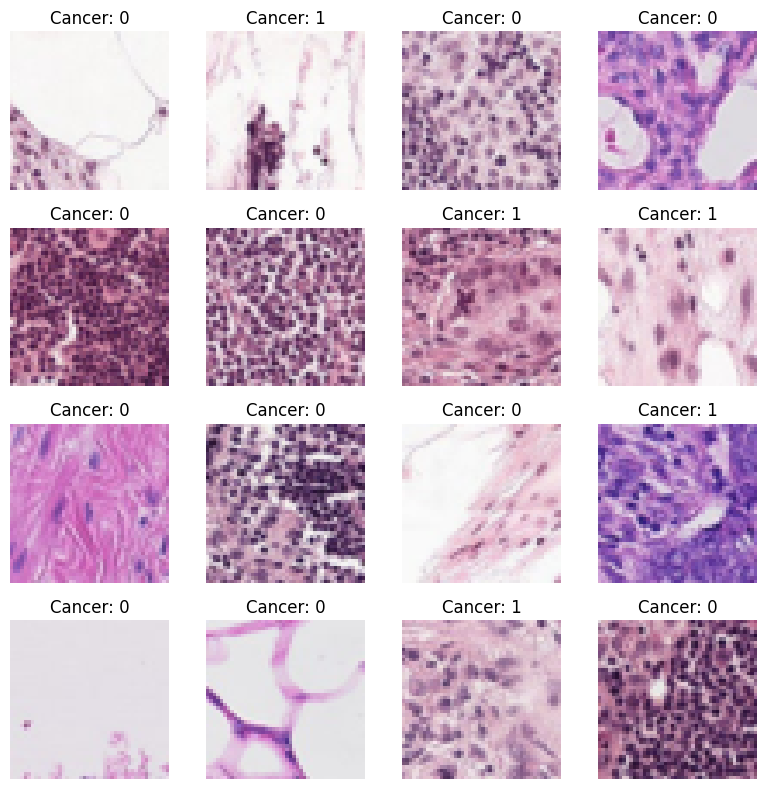

In [ ]:
def show_imgs(df,num_img = 16):
    plt.figure(figsize=(8,8))

    for i in range(num_img):
        img,lbl = df[i]
        #   Retransform image to original state
        img = 0.5*img + 0.5 #   [-1,1] -> [0,1]
        np_img = img.numpy().transpose((1,2,0))   #   (D,H,W) -> (H,W,D)

        plt.subplot(4,4,i+1)
        plt.imshow(np_img)
        plt.title(f"Cancer: {lbl}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_imgs(df)

##### No easy visual cues for cancer present.
If we had to hypothesize how to predict cancer: images with a large contrast between bold, outstanding dark spots with a more uniform color may indicate cancer. <br>
If we choose to investigate this further, maybe contrast of color depths is a significant factor.

##### Compare Pixel Intensity
From this hypothesis, let's look into pixel distributions between cancerous and noncancerous images. <br><br>
Steps: Convert to grayscale to flatten the arrays into one dimension. Then, plot the distributions of pixel values.

In [ ]:
def manually_sample(size):
    pos = []
    neg = []
    for i in range(len(df)):
        rand_i = np.random.randint(len(df))
        data = df[rand_i]
        if len(pos) == size and len(neg) == size:
            break
        if data[1] == 1 and len(pos) < size:
            pos.append(df[rand_i])

        elif data[1] == 0 and len(neg) < size:
            neg.append(df[rand_i])
    return pos,neg

ex_pos,ex_neg = manually_sample(2)

In [ ]:
import torchvision.transforms.functional as F

def show_hists(count):
    ex_pos,ex_neg = manually_sample(count)

    for i in range(len(ex_pos)):
        gray_example_cancerous = F.rgb_to_grayscale(ex_pos[i][0], num_output_channels=1).flatten()
        gray_example_noncancerous = F.rgb_to_grayscale(ex_neg[i][0], num_output_channels=1).flatten()

        plt.hist(gray_example_cancerous, bins=100, range=[0, 1],alpha=0.8,label='Cancerous')
        plt.title(f"Pixel Intensity Cancerous vs Noncancerous Images (Sample {i+1})")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.hist(gray_example_noncancerous, bins=100, range=[0, 1],alpha=0.8,label='Noncancerous')
        plt.legend()
        plt.show()

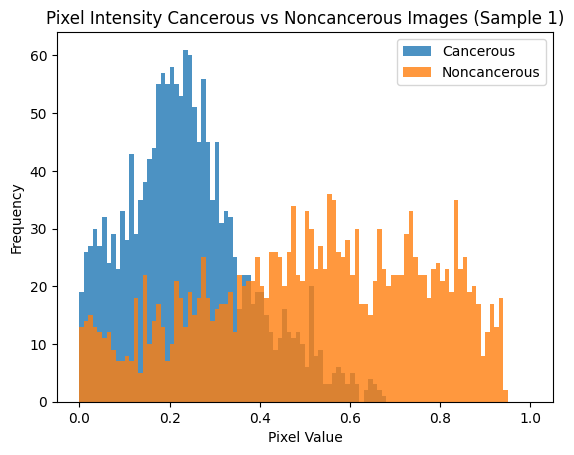

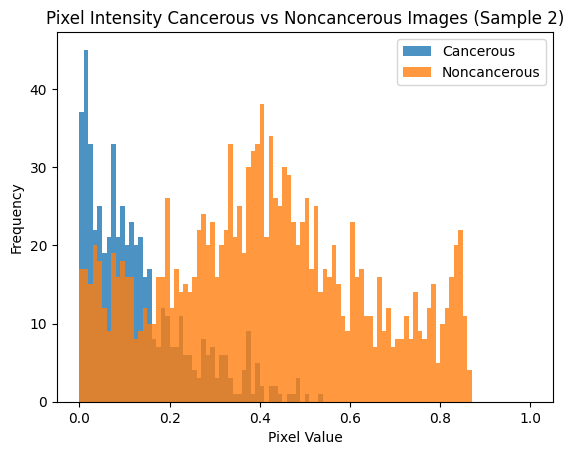

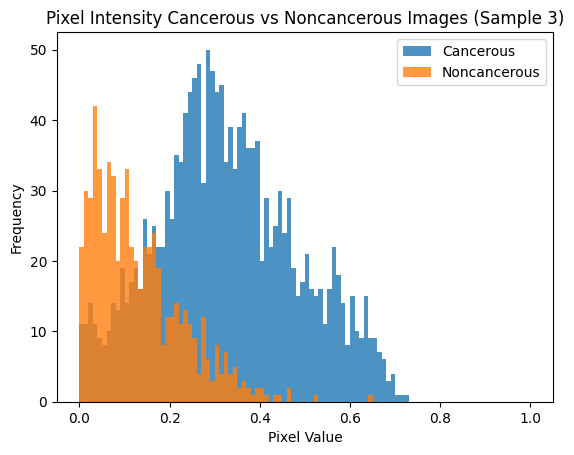

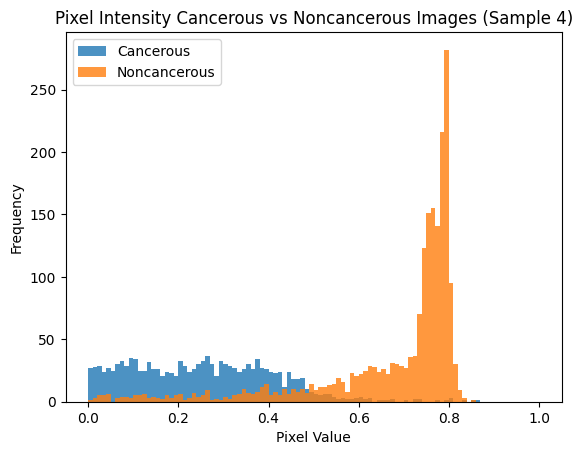

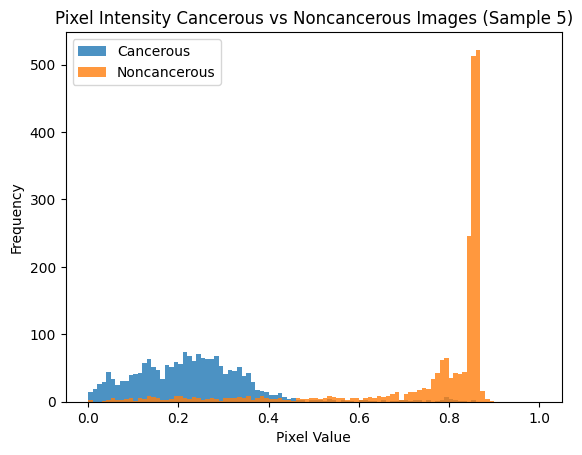

In [ ]:
show_hists(5)

##### No apparent evidence
There is no obvious difference between cancerous and non cancerous grayscale pixel values. <br>
However, this grayscale transformation is achieved by simply taking a weighted average of the RGB pixel values.

##### Next: Perform PCA for dimension reduction for visualization
This approach will reduce our dimensions by preserving components with the highest variance.

# Design Phase
Now we will build our model architectures

### First iteration
<b>Hypothesis:</b> <br>
Given the absence of obvious visual cues during exploratory data analysis (EDA), we hypothesize that cancerous features exist in fine-grained patterns within the images. Therefore, a model capable of capturing subtle, localized features (e.g., one with small receptive fields) is necessary to detect these indicators
##### Notable characteristics
1. Resized images to 46x46 (96x96 originally)
    - Balancing performance with computational efficiency
2. 5x Convolution layers
    - Small kernel sizes
        - We used 3×3 kernels along with 1×1 kernels specifically to first capture spatial relationships, then more refined features, without losing spatial resolution.
    - Delayed pooling
        - Our delayed pooling approach (only after the final convolutional layer) preserves detail throughout the network.
    - Padding = 1 on 3x3 layers to avoid shrinkage
    - Batch Normalization after each Conv. layer
        - Since this iteration was highly focused on details, it is important to account for overfitting on noise.
    - Dropout (0.3) to avoid overfitting

### Second iteration
Now we will compare our first iteration to one that focuses on broader trends and patterns in the images.

1. 4x Convolution layers
    - Large kernel sizes
        - Using 5x5 kernels to capture broad patterns.
    - Aggressive pooling
        - Max pool after each convolutional layer to reduce resolution for a broad-pattern focus.
    - Large Dropout (0.5) to avoid overfitting.
        - It is necessary to account for overfitting as this approach may be more susceptible to it.

Due to issues with Windows, I was only able to utilize my GPU within a separate .py file. <br>
Run 'train.py', then this cell will pull the results <br>

## Followup Changes
Due to the long processing time of training, I have included some attempted changes that I did not explicitly show

- Early Stopping
    - Both models' validation losses seem to diverge from the training loss, suggesting overfitting.
    - Early stopping showed no improvements on either iteration.
    - Both low and high patience did not see improvement. While it slightly lowered false negatives, the decrease in AUC was not sufficiently accounted for.

- LR Scheduling
    - Attempted this because the 2nd iteration seems to have plateaud on it's validation loss.
    - Additionally, it may help with the overfitting problem.
    - Did not improve the model.
    - Reasons for this may include high amounts of noise in the images, or the limited epochs we are running to account for lack of computational efficiency on my local machine.

- Image Alterations
    - Shuffling image presentation is known to help CNN's pick up on important patterns.
    - This reflected in our data; the following alterations improved performance:
        - Randomized rotation, randomized horizontal/vertical flipping, color jitter
    

The following result analysis was done on a small subset of the data. <br>

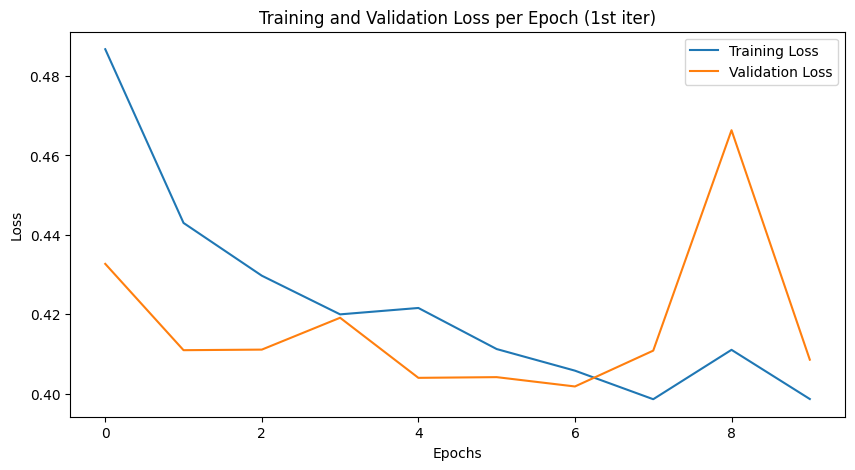

Test ROC-AUC: 0.8938 <br><br>
Confusion Matrix: <br>
[485 115] <br>
[ 64 336]

ROC-AUC score is decent, however we are getting a nearly <b>6%</b> false negative rate. Due to the importance of the topic, we want to minimize how often our model miscategorizes cancerous images as noncancerous.

### Second Iteration
Now, we will try to broaden the scope of the model to see how it compares to the first itation.

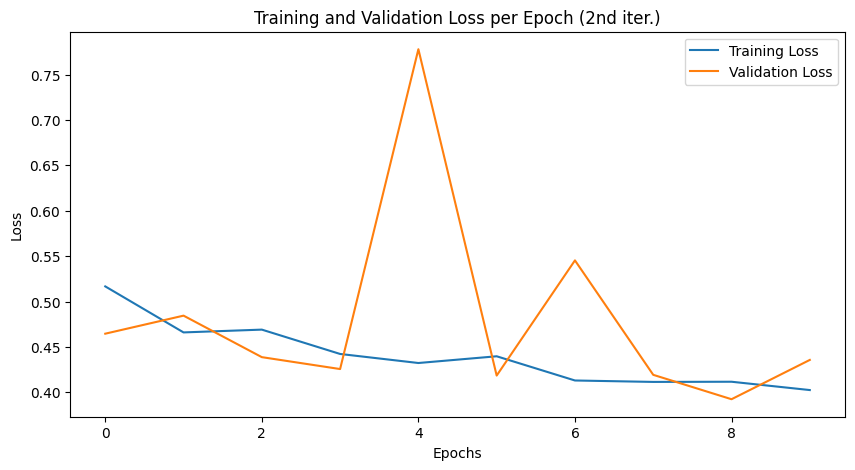

In [14]:
import json

with open("losses_i2.json", "r") as f:
    losses = json.load(f)

train_losses = losses['train_losses']
val_losses = losses['val_losses']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch (2nd iter.)')
plt.legend()
plt.show()


ROC-AUC: 0.886 <br><br>
Confusion Matrix: <br>
[545  48] <br>
[139 268]

False Negative rate greatly increased to 13% (from 6%) <br>

### Conclusion
Due to the nature of the problem, we want to minimize false-negatives as much as possible, along with maximizing performance. <br>
##### <b>For the given dataset on cancer image detection, our model focusing on small, fine details outperformed that which focused on broader, larger patterns.</b><br>
We will go along with the first iteration. <br>


### Final Results
ROC-AUC: <br>
0.9813459611111561 <br><br>
Confusion Matrix: <br>
[23973  2300]<br>
[883 16849]

Our final model has false negative rate down to 2%

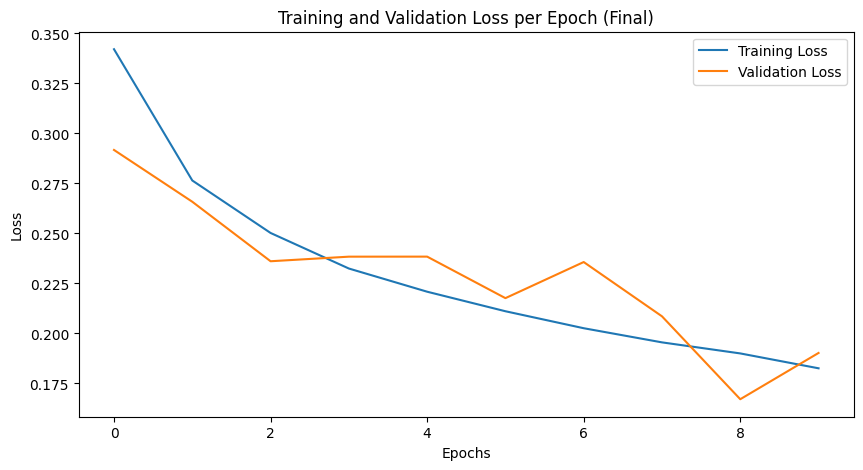

In [18]:
import json

with open("losses_i1.json", "r") as f:
    losses = json.load(f)

train_losses = losses['train_losses']
val_losses = losses['val_losses']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch (Final)')
plt.legend()
plt.show()


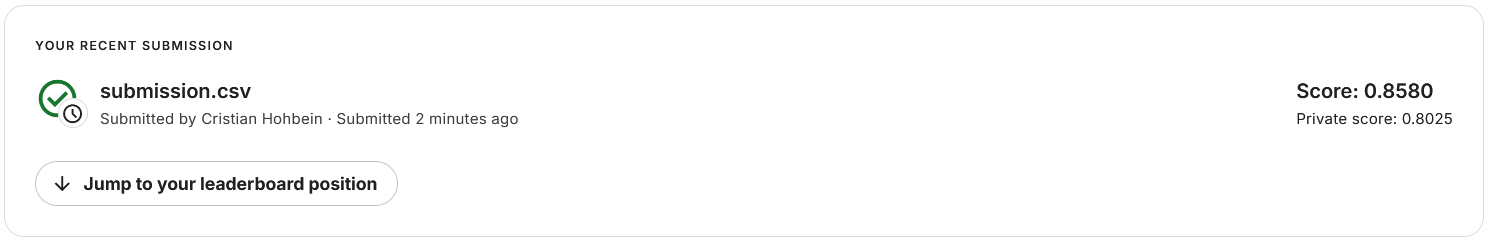